In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 as cv
import math

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

In [2]:
df_train = pd.read_csv('train.csv')
df_train.head()

,ID,Epidural,Intraparenchymal,Intraventricular,Subarachnoid,Subdural
0,ID_9ad0ba0a1.png,0,0,0,1,1
1,ID_44b817bfd.png,0,1,1,0,0
2,ID_4ac1127f3.png,0,1,0,0,0
3,ID_1d34732e5.png,0,0,0,0,1
4,ID_9947bc12e.png,0,0,0,0,1


In [3]:
df_val = pd.read_csv('val.csv')
df_val.head()

,ID,Epidural,Intraparenchymal,Intraventricular,Subarachnoid,Subdural
0,ID_b7c8b5a05.png,0,1,0,0,0
1,ID_b7c9d6cb9.png,0,1,0,0,0
2,ID_b7ca64980.png,0,0,0,0,1
3,ID_b7caa1d68.png,0,1,0,0,0
4,ID_b7cb5cb12.png,0,1,0,1,1


In [4]:
df_test = pd.read_csv('test.csv')
df_test.head()

,ID,Epidural,Intraparenchymal,Intraventricular,Subarachnoid,Subdural
0,ID_d2a94c3b7.png,0,0,0,0,1
1,ID_d2a98c0f1.png,0,0,1,1,0
2,ID_d2a9d6921.png,0,1,0,1,0
3,ID_d2a9f7ff7.png,0,0,0,0,1
4,ID_d2aa11e41.png,0,0,0,1,1


In [5]:
labels = ['Epidural','Intraparenchymal','Intraventricular','Subarachnoid','Subdural']

In [6]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=16, seed=1):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        rotation_range = 90,
                                        shear_range=0.2,
                                        zoom_range=0.1,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        fill_mode='nearest', cval=0.0)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed)
    
    return generator

In [7]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, 
                                 sample_size=500, batch_size=16, seed=1):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="ID", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True)
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed)

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed)
    
    return valid_generator, test_generator

In [8]:
IMAGE_DIR = "C:/Users/asarkar.NATICK-NT/ICH_dataset/ICH_png"
train_generator = get_train_generator(df_train, IMAGE_DIR, "ID", labels)
valid_generator, test_generator= get_test_and_valid_generator(df_val, df_test, df_train, IMAGE_DIR, "ID", labels)

getting train generator...
Found 74790 validated image filenames.
getting train and valid generators...
Found 74790 validated image filenames.
Found 10000 validated image filenames.
Found 17101 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


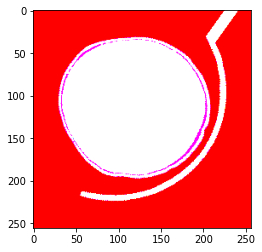

In [9]:
x, y = train_generator.__getitem__(3)
plt.imshow(x[0], cmap = 'gray');

In [10]:
y[0]

array([0, 0, 0, 0, 1], dtype=int64)

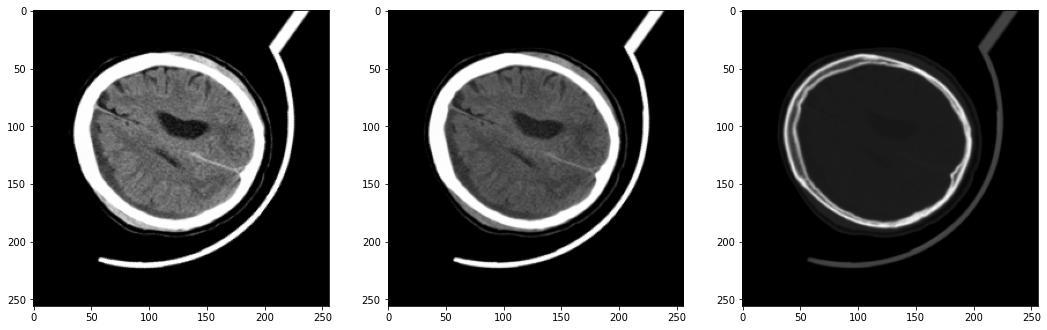

In [11]:
blue, green, red = cv.split(x[0])

fig = plt.figure(figsize = (18, 8))
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(blue, cmap = 'gray')
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(green, cmap = 'gray')
ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(red, cmap='gray')

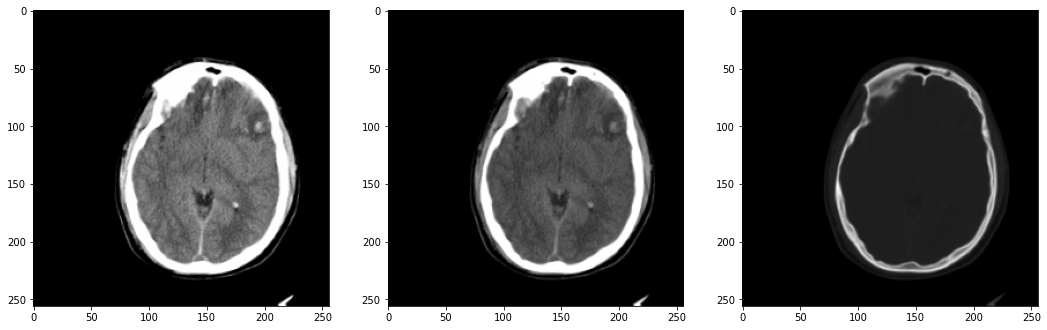

In [12]:
blue, green, red = cv.split(x[1])

fig = plt.figure(figsize = (18, 8))
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(blue, cmap = 'gray')
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(green, cmap = 'gray')
ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(red, cmap='gray')

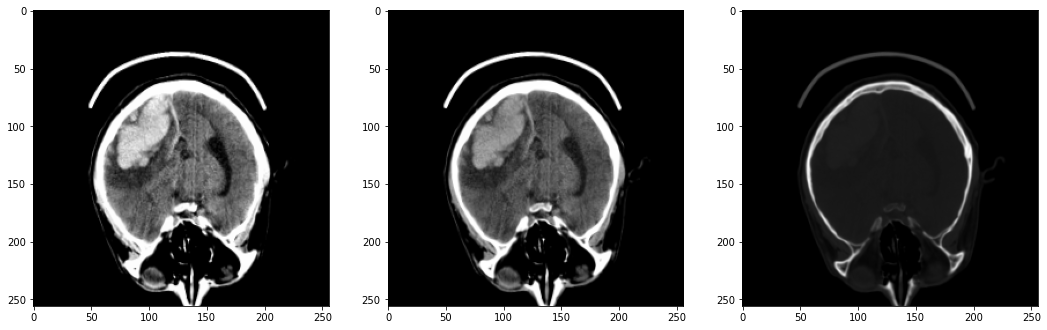

In [13]:
blue, green, red = cv.split(x[2])

fig = plt.figure(figsize = (18, 8))
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(blue, cmap = 'gray')
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(green, cmap = 'gray')
ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(red, cmap='gray')

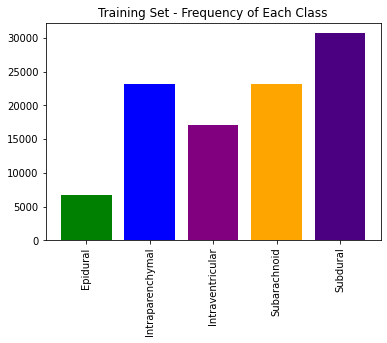

In [14]:
plt.xticks(rotation=90)
colours = ['green','blue','purple','orange','indigo']
plt.bar(x=labels, height=np.sum(train_generator.labels, axis=0), color=colours)
plt.title("Training Set - Frequency of Each Class")
plt.show()

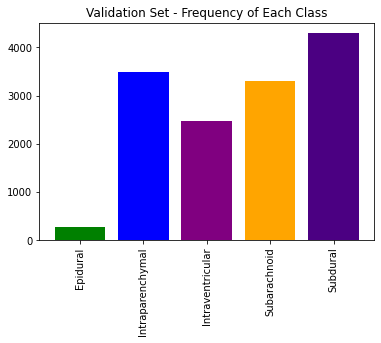

In [15]:
plt.xticks(rotation=90)
colours = ['green','blue','purple','orange','indigo']
plt.bar(x=labels, height=np.sum(valid_generator.labels, axis=0), color=colours)
plt.title("Validation Set - Frequency of Each Class")
plt.show()

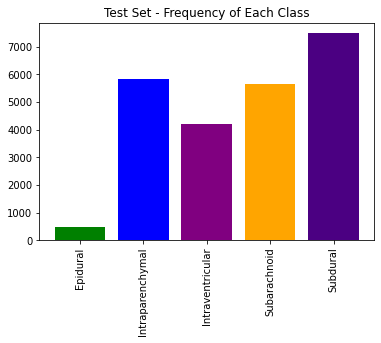

In [16]:
plt.xticks(rotation=90)
colours = ['green','blue','purple','orange','indigo']
plt.bar(x=labels, height=np.sum(test_generator.labels, axis=0), color=colours)
plt.title("Test Set - Frequency of Each Class")
plt.show()

In [17]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels==True,axis=0)/N
    negative_frequencies = np.sum(labels==False, axis=0)/N

    ### END CODE HERE ###
    return positive_frequencies, negative_frequencies

In [18]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.09056024, 0.3107501 , 0.22847974, 0.30957347, 0.41057628])

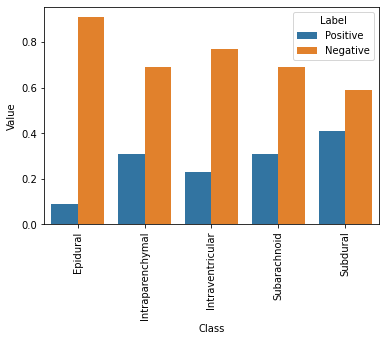

In [19]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [20]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

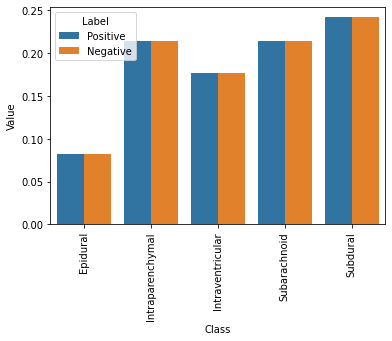

In [21]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [22]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0

        for i in range(len(pos_weights)):
            
            y_true = tf.cast(y_true, tf.float32)
            y_pred = tf.cast(y_pred, tf.float32)
            

            # for each class, add average weighted loss for that class 
            loss += K.mean(-(pos_weights[i] *y_true[:,i] * K.log(y_pred[:,i] + epsilon) 
                     + neg_weights[i]* (1 - y_true[:,i]) * K.log( 1 - y_pred[:,i] + epsilon)))   
            
        return loss
    
    return weighted_loss

In [23]:
# create the base pre-trained model
path_to_weights = "efficientnet-b4_noisy-student_notop.h5"
base_model = EfficientNetB4(include_top=False)
base_model.load_weights(path_to_weights, by_name=True)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

x = Dense(1024, kernel_regularizer=l2(0.0003),activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, kernel_regularizer=l2(0.0003),activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(1024, kernel_regularizer=l2(0.0003),activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(1024, kernel_regularizer=l2(0.0003),activation='relu')(x)
x = Dropout(0.2)(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='sgd', loss=get_weighted_loss(pos_weights, neg_weights), metrics = ['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_______________________________________________________________________________________

In [24]:
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

stopping = EarlyStopping(monitor='val_loss', patience=5)

callbacks = ModelCheckpoint('EfficientNetB4_sgd_noisy.h5', monitor='val_loss', save_best_only=True, mode = 'auto')

Epoch 1/100
4625/4625 [==============================] - 1487s 322ms/step - loss: 2.4610 - accuracy: 0.3400 - val_loss: 2.2496 - val_accuracy: 0.5055
Epoch 2/100
4625/4625 [==============================] - 1479s 320ms/step - loss: 2.1813 - accuracy: 0.5214 - val_loss: 2.0109 - val_accuracy: 0.5938
Epoch 3/100
4625/4625 [==============================] - 1478s 320ms/step - loss: 1.9939 - accuracy: 0.5880 - val_loss: 1.8679 - val_accuracy: 0.6553
Epoch 4/100
4625/4625 [==============================] - 1488s 322ms/step - loss: 1.8589 - accuracy: 0.6322 - val_loss: 1.7564 - val_accuracy: 0.6757
Epoch 5/100
4625/4625 [==============================] - 1480s 320ms/step - loss: 1.7490 - accuracy: 0.6626 - val_loss: 1.6721 - val_accuracy: 0.6944
Epoch 6/100
4625/4625 [==============================] - 1481s 320ms/step - loss: 1.6614 - accuracy: 0.6789 - val_loss: 1.5791 - val_accuracy: 0.7052
Epoch 7/100
4625/4625 [==============================] - 1478s 320ms/step - loss: 1.5780 - accuracy:

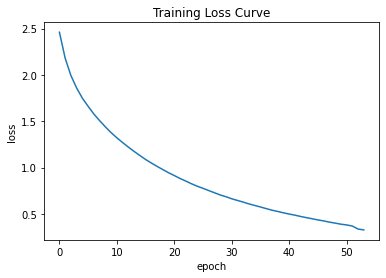

In [25]:
batch_size = 16

train = 74000
val = 10000
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))

steps_per_epoch = compute_steps_per_epoch(train)
val_steps = compute_steps_per_epoch(val)

history = model.fit(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=steps_per_epoch, 
                              validation_steps=val_steps, 
                              epochs = 100,
                              callbacks = [callbacks,lr_schedule,stopping])

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

In [26]:
model_2 = tf.keras.models.load_model('EfficientNetB4_sgd_noisy.h5', compile = False)
model_2.compile(optimizer='sgd', loss=get_weighted_loss(pos_weights, neg_weights), metrics = ['accuracy'])

predicted_vals = model_2.predict(test_generator, steps = len(test_generator))

In [27]:
import random

from tensorflow.keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity

In [28]:
def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

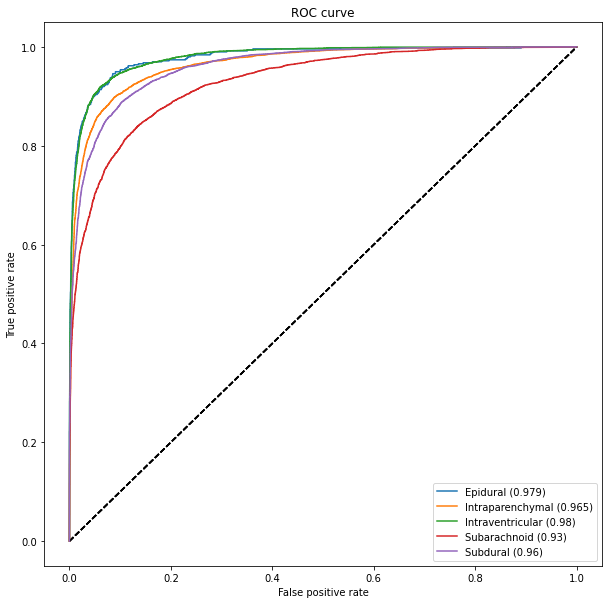

In [29]:
auc_rocs = get_roc_curve(labels, predicted_vals, test_generator)

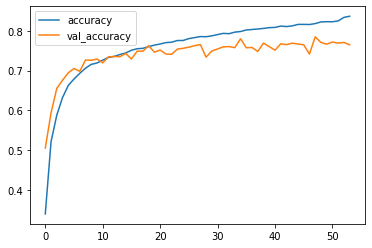

In [30]:
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()

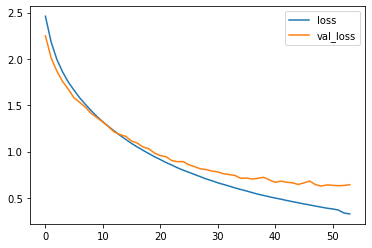

In [31]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()

Confusion matrix for label Epidural:


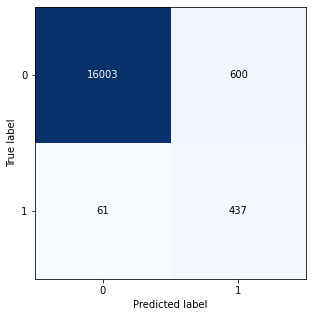

Metrics for label : Epidural

Sensitivity-Recall : 0.8775100401606426
Precision - PPV : 0.4214079074252652
Accuracy : 0.9613472896321853
F-score : 0.5693811074918567

Confusion matrix for label Intraparenchymal:


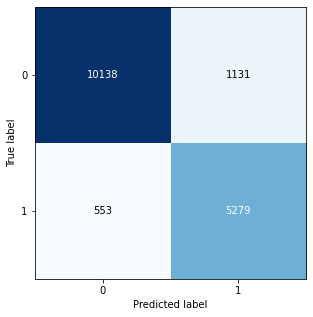

Metrics for label : Intraparenchymal

Sensitivity-Recall : 0.9051783264746228
Precision - PPV : 0.8235569422776912
Accuracy : 0.9015262265364599
F-score : 0.8624407776507107

Confusion matrix for label Intraventricular:


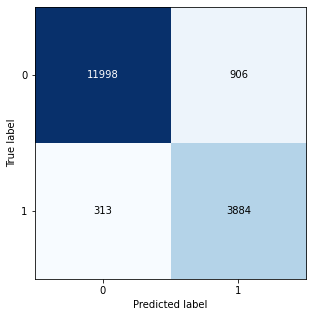

Metrics for label : Intraventricular

Sensitivity-Recall : 0.9254229211341435
Precision - PPV : 0.8108559498956158
Accuracy : 0.9287176188526987
F-score : 0.8643596305775008

Confusion matrix for label Subarachnoid:


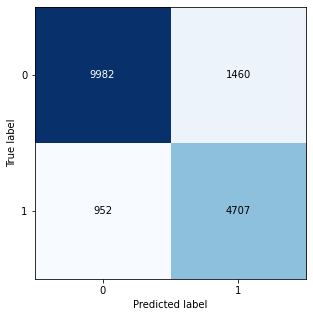

Metrics for label : Subarachnoid

Sensitivity-Recall : 0.8317723979501679
Precision - PPV : 0.7632560402140425
Accuracy : 0.8589556166306064
F-score : 0.7960426179604262

Confusion matrix for label Subdural:


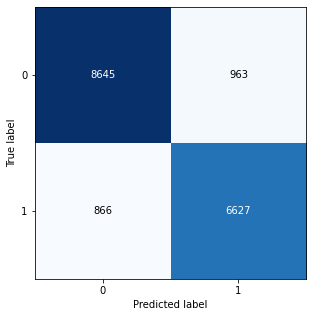

Metrics for label : Subdural

Sensitivity-Recall : 0.8844254637661818
Precision - PPV : 0.8731225296442687
Accuracy : 0.893047190222794
F-score : 0.8787376516608101

Metrics for Model

Sensitivity-Recall : 0.8840744963892057
Precision - PPV : 0.8053396937754866
Accuracy : 0.9087187883749488
F-score : 0.8428723854005195


In [32]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

TP_all =0
TN_all =0
FP_all =0
FN_all =0

conf_mat_dict={}

for i in range(len(labels)):
    gt = test_generator.labels[:, i]
    pred = predicted_vals[:, i]
    pred = np.rint(pred)
    conf_mat_dict[labels[i]] = confusion_matrix(y_pred=pred, y_true=gt)
    
for label, matrix in conf_mat_dict.items():
    print("Confusion matrix for label {}:".format(label))
    plot_confusion_matrix(matrix,figsize=(5,5))
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
    
    TN = matrix[0][0]
    FN = matrix[1][0]
    TP = matrix[1][1]
    FP = matrix[0][1]
    
    print("Metrics for label : {}".format(label))
    print("")
    
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    print("Sensitivity-Recall : {}".format(TPR))
    
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    print("Precision - PPV : {}".format(PPV))
    
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    print("Accuracy : {}".format(ACC))
    
    #F-score
    F_score = (2*PPV*TPR)/(PPV+TPR)
    print("F-score : {}".format(F_score))
    print("")
    
    TP_all = TP_all + TP
    TN_all = TN_all + TN
    FP_all = FP_all + FP
    FN_all = FN_all + FN
    
print("Metrics for Model")
print("")
    
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP_all/(TP_all+FN_all)
print("Sensitivity-Recall : {}".format(TPR))
    
# Precision or positive predictive value
PPV = TP_all/(TP_all+FP_all)
print("Precision - PPV : {}".format(PPV))
    
# Overall accuracy
ACC = (TP_all+TN_all)/(TP_all+FP_all+FN_all+TN_all)
print("Accuracy : {}".format(ACC))
    
#F-score
F_score = (2*PPV*TPR)/(PPV+TPR)
print("F-score : {}".format(F_score))